# Introduction

# Imports 

In [14]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Read Data

In [15]:
df = pd.read_csv("../data/toy_data.csv", index_col=0)

In [16]:
df.head()

,pressure (psi),temperature (deg F),failure
0,15.020932,192.804706,yes
1,15.344324,199.772074,yes
2,15.089475,197.309593,yes
3,14.220017,199.039052,yes
4,14.235332,205.322159,yes


# Visualize The dataset

In [17]:
x_label = 'pressure (psi)'
y_label = 'temperature (deg F)'
target_label = 'failure'

In [18]:
df['color'] = df[target_label].map({'no':'green', 'yes':'red'})
df_yesses = df[df[target_label]=='yes']
df_nos = df[df[target_label]=='no']

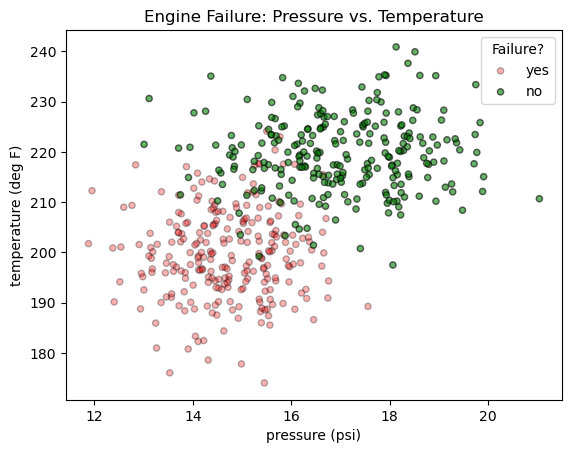

In [19]:
fig, ax = plt.subplots(1,1)

ax.scatter(df_yesses[x_label], df_yesses[y_label], c=df_yesses['color'], s=20, edgecolor="k", label='yes', alpha=0.3)


ax.scatter(df_nos[x_label], df_nos[y_label], c=df_nos['color'], s=20, edgecolor="k", label='no', alpha=0.6)

ax.set_title('Engine Failure: Pressure vs. Temperature')
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend(title='Failure?')

plt.show()

# Generate Training and Testing Data

In [20]:
# Separate feature names from class names
feat_names = [x_label, y_label]
unique_labels = df[target_label].unique()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df[feat_names],
                                                    df[target_label],
                                                    test_size=0.25,
                                                    random_state=42)

# Training and Fitting the Model

In [22]:
log_reg_classifier = LogisticRegression(random_state=0)
log_reg_classifier = log_reg_classifier.fit(X_train, y_train)

# Making Predictions

In [23]:
predictions = log_reg_classifier.predict(X_test)
probabilities = log_reg_classifier.predict_proba(X_test)
results_df = pd.DataFrame({'prob of no':probabilities[:,0],
                         'prob of yes':probabilities[:,1],
                         'predicted class':predictions,
                         'actual class': y_test})
results_df.head()

,prob of no,prob of yes,predicted class,actual class
361,0.999950,0.000050,no,no
73,0.000237,0.999763,yes,yes
374,0.947341,0.052659,no,no
155,0.054426,0.945574,yes,yes
104,0.007709,0.992291,yes,yes


# Checking Accuracy

In [24]:
accuracy = log_reg_classifier.score(X_test, y_test)
accuracy

0.912

# Visualizing Decision Boundaries

In [25]:
colors = []
for y in y_test:
    if y == 'yes':
        colors.append('red')
    else:
        colors.append('green')
X_test_copy = X_test.copy(deep=True)
        
X_test_copy['type'] = y_test
X_test_copy['color'] = colors

test_yesses = X_test_copy[X_test_copy['type']=='yes']
test_nos = X_test_copy[X_test_copy['type']=='no']

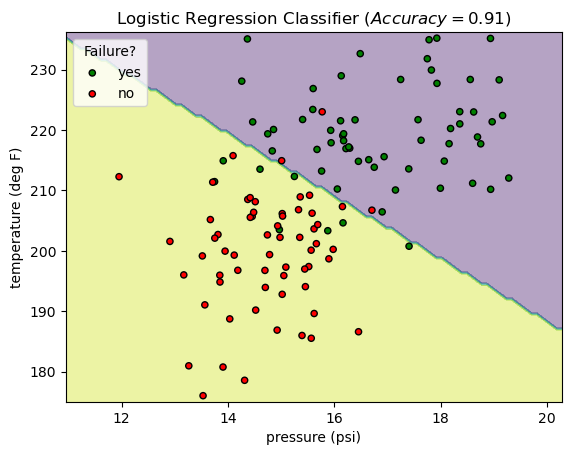

In [26]:
fig, ax = plt.subplots(1,1)
DecisionBoundaryDisplay.from_estimator(log_reg_classifier, X_test, alpha=0.4, response_method="predict", ax=ax)

ax.scatter(test_nos[x_label], test_nos[y_label], c=test_nos['color'], s=20, edgecolor="k", label='yes')

ax.scatter(test_yesses[x_label], test_yesses[y_label], c=test_yesses['color'], s=20, edgecolor="k", label='no')

ax.legend(title='Failure?')
ax.set_title(f'Logistic Regression Classifier $(Accuracy = {accuracy:.2f})$')

#plt.tight_layout()
plt.show()

# Confusion Matrix

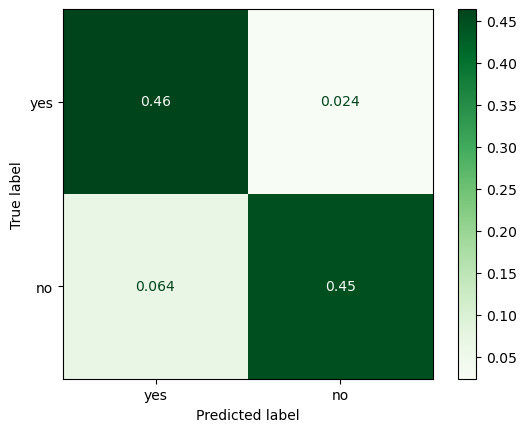

In [27]:
cm = confusion_matrix(y_test, predictions,
                      labels=unique_labels,
                      normalize='all')
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
cm_display.plot(cmap='Greens')
plt.show()